## Phase 3

Main goals:
* To create meaningful OLAP queries that can help processes and stakeholders.
* To identify bottlenecks and make performance analysis, discussing its growth.
* To make a critical assessment of the whole project.

Comments are written in Portuguese.


-----------------------------

#### Funções utilitárias

In [2]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML

HOST = "10.101.151.25"
DATABASE = "tpd017"
USER = "tpd017"
PASSWORD = "tpd017" 

# Execute a single statement.
def execute_single_sql_statement(sql):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)    
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

# Return output of query in dataframe
def getSQLfromQuery(sql, params):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)
    cur  = conn.cursor()    
    if len(params)==0:
        cur.execute(sql)
    else: 
        cur.execute(sql, params)
    data = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    cur.close()
    conn.close()
    df=pandafy(data, colnames)
    return df

# Create a dataframe
def pandafy(rows, colnames):
    N=len(colnames)
    D={cn: [] for cn in colnames}
    for row in rows:
        for i in range(N): D[colnames[i]].append(row[i])
    pdfy=pd.DataFrame(D)
    return pdfy


## 1. Implementação de *queries* OLAP

Para esta fase propomos um conjunto de interrogações que consideramos relevantes para o contexto deste *data warehouse*, sendo explicado os seus objetivos, as dimensões e atributos implicados nas interrogações, e a relevância para os processos de negócio interessados que foram referidos ao longo das fases anteriores. 

Também, dada a impossibilidade de criar *dashboards*, vamos também tentar propor para cada *query* uma possível visualização que ofereça uma outra abordagem para entender os resultados.

-----------------

1. **Há algum período do dia onde ocorrem mais acidentes? Este padrão ocorre de forma semelhante para as várias regiões dos EUA? Esses períodos correspondem a horas de maior movimento, como rush hours?**


* **Objectivo da interrogação**: Analisar o número de ocorrências de acidentes ao nível da região e subregião (roll-up e drill-down) em relação ao período do dia.
* **Dimensões relevantes para a query**:
    * Facts Table: ligação entre as dimensões Location e LocalTIme (atributos `LocationKey` e `LocalTimeKey`)
    * Location: para agrupar as ocorrências segundo os atributos `Region` e `Subregion`
    * LocalTime: para agrupar as ocorrências segundo o atributo `PeriodOfDay`
* **Relevância para quais processos?**
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação

**Interrogação**:

``
SELECT l.region, l.subregion, t.period_of_day, COUNT(*) AS number_of_accidents
FROM local_time_dimension t, location_dimension l, facts_table ft
WHERE t.local_time_key = ft.local_timekey AND l.location_key = ft.locationkey
GROUP BY l.region, l.subregion, t.period_of_day
ORDER BY l.region DESC
``

In [3]:
SQL = """
SELECT l.region, l.subregion, t.period_of_day, COUNT(*) AS number_of_accidents
FROM local_time_dimension t, location_dimension l, facts_table ft
WHERE t.local_time_key = ft.local_timekey AND l.location_key = ft.locationkey
GROUP BY l.region, l.subregion, t.period_of_day
ORDER BY l.region DESC
"""

df = getSQLfromQuery(SQL, ())

In [4]:
table = pd.pivot_table(df, 
                       values=['number_of_accidents'], 
                       index=['region', 'subregion', 'period_of_day'], 
                       aggfunc={'number_of_accidents': np.sum},)

table

number_of_accidents
region                           subregion                        period_of_day                                        
Midwest                          East North Central               Day                                              1544
                                                                  Dusk                                              413
                                                                  Evening Rush Hour                                 604
                                                                  Lunch Time                                        359
                                                                  Morning Rush Hour                                 807
                                                                  Night                                             734
                                 West North Central               Day                                               669
                                                                  Dusk                                              225
                                                                  Evening Rush Hour                                 295
                                                                  Lunch Time                                        190
                                                                  Morning Rush Hour                                 312
                                                                  Night                                             311
Northeast                        Mid Atlantic                     Day                                              1732
                                                                  Dusk                                              402
                                                                  Evening Rush Hour                                 521
                                                                  Lunch Time                                        373
                                                                  Morning Rush Hour                                 865
                                                                  Night                                             677
                                 New England                      Day                                               521
                                                                  Dusk                                              139
                                                                  Evening Rush Hour                                 183
                                                                  Lunch Time                                         98
                                                                  Morning Rush Hour                                 201
                                                                  Night                                             136
South                            East South Central               Day                                               861
                                                                  Dusk                                              163
                                                                  Evening Rush Hour                                 285
                                                                  Lunch Time                                        156
                                                                  Morning Rush Hour                                 363
                                                                  Night                                             264
                                 South Atlantic                   Day                                              4129
                                                                  Dusk                                              983
                    

--------------------------------------------

2. **Assumindo que os diferentes níveis de urbanismo nos municípios afetam a quantidade de tráfego nos mesmos, esse aumento também vai ocorrer no número de acidentes e na severidade dos mesmos?** 


* **Objetivo da interrogação**: Análise e visualização, para cada nível de urbanismo, do número de acidentes, e da distribuição da severidade nos mesmos, de modo a entender padrões à medida que o urbanismo aumenta.
* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Location (atributo `LocationKey`)
    * Location: para recolha dos diferentes níveis de urbanismo (atributo `UrbanRuralClassification`)
    * Severity: para recolha das diferentes severidades dos acidentes (atributo-chave `SeverityKey`)
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores através da prevalência de determinados acidentes em certas zonas
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação
    * Estruturas de controlo de tráfego: recolha de informação para identificação de zonas mais vulneráveis

**Interrogação**:

``
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
``


In [5]:
SQL="""
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
"""

df = getSQLfromQuery(SQL, ())
df['urban_rural_classification'] = df['urban_rural_classification'].apply(lambda x: x.rstrip())

table = pd.pivot_table(df, index=['severitykey'],margins=True, columns=['urban_rural_classification'] ).fillna(0).astype(int)
table

number_of_accidents                     \
urban_rural_classification Large Central Metro Large Fringe Metro   
severitykey                                                         
1                                            5                  4   
2                                        12664               4504   
3                                         5840               2374   
4                                          233                297   
All                                       4685               1794   

                                                                           \
urban_rural_classification Medium Metro Micropolitan Non-Core Small Metro   
severitykey                                                                 
1                                     4            0        3           2   
2                                  5234         2080     6178        1796   
3                                  1954          899     2670         527   
4                                   260          173      337         138   
All                                1863         1050     2297         615   

                                  
urban_rural_classification   All  
severitykey                       
1                              3  
2                           5409  
3                           2377  
4                            239  
All                         2094

##### Possível visualização dos dados:

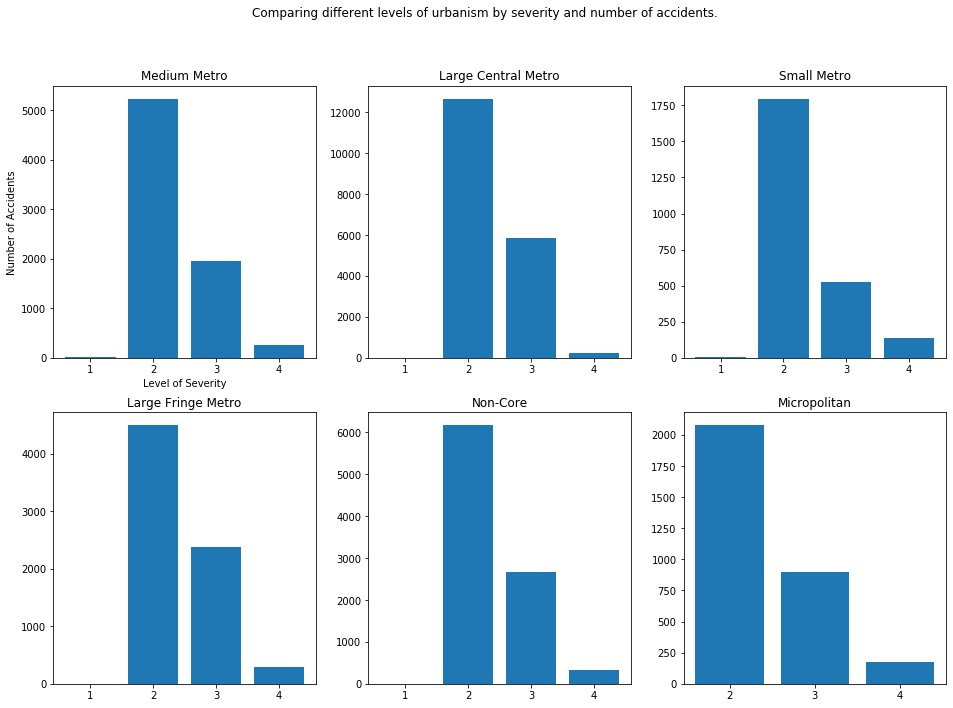

In [6]:
classes = list(set(df['urban_rural_classification'].values))
fig, axs = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Comparing different levels of urbanism by severity and number of accidents.')

for i, ax in enumerate(fig.axes):
    test = df.loc[df['urban_rural_classification'] == classes[i]].drop(columns=['urban_rural_classification'])

    ax.set_xticks(test['severitykey'].values)
    ax.bar(test['severitykey'].values, test['number_of_accidents'].values)
    ax.set_title(classes[i])
    if i == 0: 
        ax.set_xlabel("Level of Severity")
        ax.set_ylabel("Number of Accidents")
plt.show()

---------------------------------------------

3. **Assumindo que a condição de 'piso escorregadio' influi negativamente nos acidentes, qual será o impacto de algumas condições metereológicas tipicamente associadas a esta condição na distância e duração média dos acidentes verificados?**


* **Objetivo da interrogação**: Análise e visualização, para os atributos metereológicos selecionados, a duração média e a distância média dos acidentes, de modo a entender os padrões que mais contribuem para acidentes tipicamente associados a piso escorregadio.

* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Weather (atributo `weather_key`)
    * Weather: para recolha dos diferentes atributos metereológicos (atributos `precipitation`,`weathercondition`,`humidity` )
* **Relevância para quais processos?**
    * Estruturas de controlo de tráfego: estudo das condições e emissão de alertas aos condutores.

**Interrogação**:

``
Select weather_dimension.precipitation as precipitation, 
		weather_dimension.weather_condition as weathercondition, 
		weather_dimension.humidity as humidity, 
		avg(facts_table.distance) as average_distance,
		avg(facts_table.duration) as average_duration,
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
	   and weather_dimension.weather_condition not like '%Unknown%'
	   and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
``


In [7]:
SQL="""
select weather_dimension.precipitation as precipitation, 
        weather_dimension.weather_condition as weathercondition, 
        weather_dimension.humidity as humidity, 
        avg(facts_table.distance) as average_distance,
        avg(facts_table.duration) as average_duration
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
       and weather_dimension.weather_condition not like '%Unknown%'
       and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
"""

df = getSQLfromQuery(SQL, ())

In [8]:
df['precipitation'] = df['precipitation'].apply(lambda x: x.rstrip())
df['weathercondition'] = df['weathercondition'].apply(lambda x: x.rstrip())
df['humidity'] = df['humidity'].apply(lambda x: x.rstrip())

df['average_duration'] = df['average_duration'].astype(np.int64)
table = pd.pivot_table(df, values=['average_distance','average_duration'],margins=True, index=['precipitation', 'weathercondition', 'humidity'], aggfunc={'average_distance':np.mean, 'average_duration': np.mean})
table['average_duration'] = pd.to_timedelta(table['average_duration'])
table

average_distance  \
precipitation              weathercondition humidity                                         
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0            0.188357   
                                            (Low) rate <= 25.0                    0.006667   
                                            (Medium) 25.0 < rate <= 50.0          0.049300   
                                            (Very High) rate > 75.0               1.558053   
                           Cloudy           (Very High) rate > 75.0               1.695000   
...                                                                                    ...   
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0          0.010000   
                                            (Very High) rate > 75.0               0.191000   
                           Partly Cloudy    (High) 50.0 < rate <= 75.0            0.029333   
                                            (Very High) rate > 75.0               0.088000   
All                                                                               0.606243   

                                                                         average_duration  
precipitation              weathercondition humidity                                       
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0    01:11:32.964286  
                                            (Low) rate <= 25.0            00:30:37.666667  
                                            (Medium) 25.0 < rate <= 50.0  00:37:50.200000  
                                            (Very High) rate > 75.0       00:32:35.315789  
                           Cloudy           (Very High) rate > 75.0       01:11:53.500000  
...                                                                                   ...  
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0         00:44:30  
                                            (Very High) rate > 75.0              00:29:48  
                           Partly Cloudy    (High) 50.0 < rate <= 75.0    02:24:48.666667  
                                            (Very High) rate > 75.0       03:14:47.500000  
All                                                                       01:31:26.931142  

[239 rows x 2 columns]

-------------------------------

4. **Tendo em conta a média de acidentes por estado ao longo de 2019, quais os estados com número de registos superiores a essa média? E qual a evolução de acidentes ao longo dos anos para esses estados?**


* **Objetivo da interrogação**: Comparação do número de registos de acidentes nos ultimos anos, nos estados que mostram ter o maior número de acidentes;

* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Date (atributo `date_key`) e ligação à dimensão Location (atributo `location_key`) 
    * Date: para recolha dos anos registados nos vários acidentes (atributo `start_year`)
    * Location: para recolha dos estados nos quais foram registados acidentes (atributo `state`)
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores relativamente ao estado em que o veiculo está registado.
    
**Interrogação (e sub-interrogações para obter valores)**:

* Obtenção do número total de acidentes em 2019:

``
SELECT COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE  facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND date_dimension.start_year = 2019
``


* Obtenção do número de estados presentes no conjunto de dados:

``
SELECT COUNT (DISTINCT location_dimension.state)
FROM location_dimension
``


* *\[Main query\]* Definição da evolução anual de acidentes para os estados cujo número de acidentes foi acima da média em 2019:

``
SELECT location_dimension.state, date_dimension.start_year, COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND location_dimension.state IN 
                 (SELECT location_dimension.state
                FROM location_dimension , date_dimension , facts_table 
                WHERE  facts_table.locationkey = location_dimension.location_key
                    AND facts_table.datekey = date_dimension.date_key 
                    AND date_dimension.start_year = 2019
                GROUP BY location_dimension.state 
                HAVING COUNT(*) > media 
                )
    GROUP BY date_dimension.start_year,location_dimension.state
    ORDER BY location_dimension.state
``



In [9]:
SQL="""
SELECT COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE  facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND date_dimension.start_year = 2019
"""
df = getSQLfromQuery(SQL, ())
print(df)
numero = df.values

SQL="""
SELECT COUNT (DISTINCT location_dimension.state)
FROM location_dimension 

"""

df = getSQLfromQuery(SQL, ())
print(df)
media = (numero [0] /df.values[0])[0]
print("\nAverage:", media)

   number_of_accidents
0                15546
   count
0     46

Average: 337.95652173913044


In [10]:
SQL="""
SELECT location_dimension.state, date_dimension.start_year, COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND location_dimension.state IN 
                 (SELECT location_dimension.state
                FROM location_dimension , date_dimension , facts_table 
                WHERE  facts_table.locationkey = location_dimension.location_key
                    AND facts_table.datekey = date_dimension.date_key 
                    AND date_dimension.start_year = 2019
                GROUP BY location_dimension.state 
                HAVING COUNT(*) >  """+ str(media)+""" 
                )
    GROUP BY date_dimension.start_year,location_dimension.state
    ORDER BY location_dimension.state
"""


df =  getSQLfromQuery(SQL, ())
df['state'] = df['state'].apply(lambda x: x.rstrip())
table = pd.pivot_table(df, index= ['state'],margins=True, columns=['start_year'] )
table = table.astype(int)
table

number_of_accidents                        
start_year                    2016  2017  2018  2019   All
state                                                     
Arizona                         48   211   382   411   263
California                    2380  2637  2575  3674  2816
Florida                        605  1036  1039   979   914
Georgia                        182   353   412   371   329
Minnesota                       45   182   310   534   267
New York                       299   632   634   701   566
North Carolina                  97   590   967   842   624
Oregon                          15   109   373   698   298
South Carolina                  50   442  1001  1020   628
Tennessee                       23   196   450   396   266
Texas                          843  1471  1429  1338  1270
Utah                            11    61   181   414   166
All                            383   660   812   948   701

##### Possível visualização dos dados:

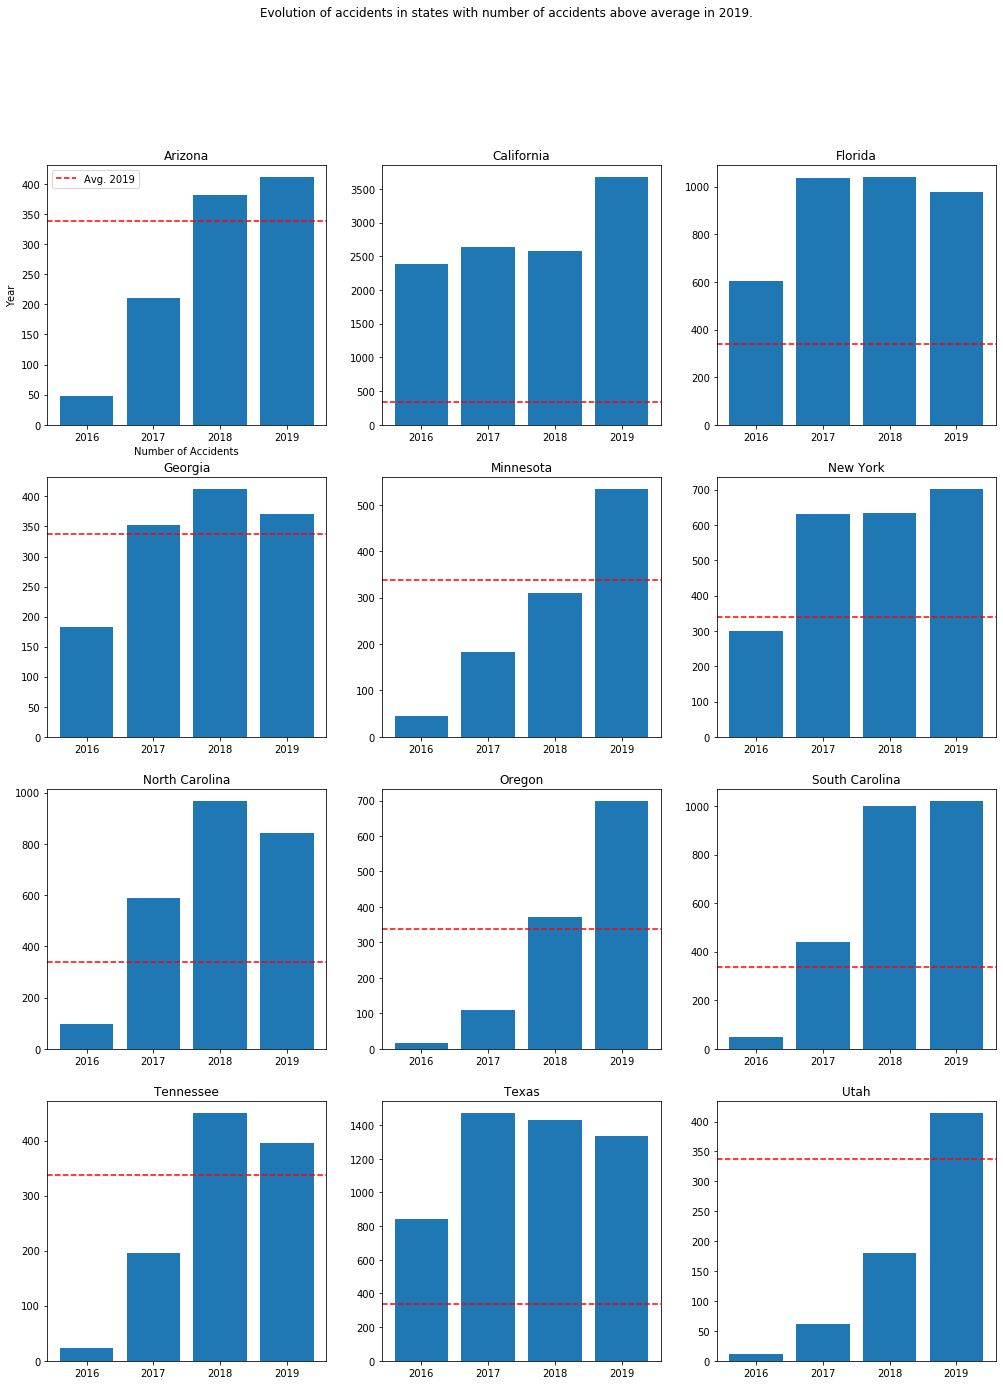

In [11]:
states = table.index.values.tolist()

fig, axs = plt.subplots(4,3, figsize=(17,22))
fig.suptitle('Evolution of accidents in states with number of accidents above average in 2019.')

for i, ax in enumerate(fig.axes):
    testdf = pd.DataFrame(table.loc[states[i]]).T

    years = []
    for elem in testdf.columns :
        years.append(elem[1])
    
    ax.set_xticks(years[:-1])
    ax.bar(years[:-1], testdf.values[0][:-1])
    ax.set_title(states[i])
    ax.axhline(y=media, color='r', linestyle='--', label='Avg. 2019') 
    if i == 0: 
        ax.set_xlabel("Number of Accidents")
        ax.set_ylabel("Year")
        ax.legend()
plt.show()

## 2. Identificação de bottlenecks e otimização das queries

Para cada uma das interrogações previstas anteriormente apresenta-se o plano gráfico e plano descritivo de execução das queries, para identificação de bottlenecks e possíveis melhorias. Apresenta-se ainda a informação relativa aos planos de execução após a realização das alterações de melhoria tidas por convenientes.

De referir que o custo associado para estas operações está definido para a *sample* de ~50000 registos que temos presente na base de dados, sendo que para uma ordem de grandeza dos milhões de registos o seu impacto seria muito mais significativo.

### 2.1 Primeira Interrogação


``
SELECT l.region, l.subregion, t.period_of_day, COUNT(*) AS number_of_accidents
FROM local_time_dimension t, location_dimension l, facts_table ft
WHERE t.local_time_key = ft.local_timekey AND l.location_key = ft.locationkey
GROUP BY l.region, l.subregion, t.period_of_day
ORDER BY l.region DESC
``

**Plano gráfico de execução sem otimização**

In [12]:
Image(url= "https://docs.google.com/uc?export=download&id=1b1E3KBf6nBUMohDpn0IG0tvDqM3jg-xU")

**Plano descritivo de execução sem otimização**

In [13]:
Image(url= "https://docs.google.com/uc?export=download&id=1YOVah4mn24lE56xpumfivnki-Xe_cVqV")

**Ações de melhoria**

* Como é possível ver pelas query plans, os maiores custos associados a esta query derivam dos dois joins efetuados pelas igualdades definidas na mesma: `t.local_time_key = ft.local_timekey` e `l.location_key = ft.locationkey`, sendo a última a que representa mais custo dado que a dimensão Location tem maior volume que a dimensão LocalTime.
* Sendo assim, decide-se colocar um **B+ Tree Index** na chave secundária `locationkey` da tabela de factos. Esse index permite que, em vez de se recorrer a um *sequential scan* sobre a tabela de factos, passe a ser feito um *index scan*, sendo esses resultados posteriormente aproveitados para a igualdade seguinte.

**`CREATE INDEX location_idx ON facts_table (locationkey)`**

**Plano gráfico de execução otimizado**

In [14]:
Image(url= "https://docs.google.com/uc?export=download&id=100tCgwBM56Zp9qWObxQCbcec2Fg-5Tyu")

**Plano descritivo de execução otimizado**

In [15]:
Image(url= "https://docs.google.com/uc?export=download&id=1eu3Ax0GCIUfeIlfSotoEzoZNZSBCdDoj")

### 2.2 Segunda Interrogação


``
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
``

**Plano gráfico de execução sem otimização**

In [16]:
Image(url= "https://docs.google.com/uc?export=download&id=1hq5i-5sLbzNHy1VahfVafZcuMHn5Ye8V")

**Plano descritivo de execução sem otimização**

In [17]:
Image(url= "https://docs.google.com/uc?export=download&id=1qlmJRyB2MI16I3CsIJCRJ7a4wo5TvPuA")

**Ações de melhoria**

* Como é possível ver pelas query plans desta query, a operação com maior custo, por larga margem, é a que envolve a ligação entre a chave secundária `locationkey` (da tabela de factos) e a chave primária `location_key` (da dimensão Location). 
* Visto que as chaves primárias das dimensões já têm indexes associados, uma possível otimização será a colocação de um index sobre a `location_key`, da tabela de factos (*index* esse também já usado anteriormente) de modo a definir melhorias sobre o *scan* efetuado na dimensão Location.

**Plano gráfico de execução otimizado**

In [18]:
Image(url= "https://docs.google.com/uc?export=download&id=1m-sF611zxWPf0ugm_So8nttu-YUUvWou")

**Plano descritivo de execução otimizado**

In [19]:
Image(url= "https://docs.google.com/uc?export=download&id=13DAK8STGt5KguFfbe4qUnJ-wjkWza8H1")

* Através da introdução do *index* referido, passa agora a ocorrer um *merge inner join* com dois *index scan* associados em vez do sequential scan sobre a tabela de factos, o que leva à redução do custo destas operações.

### 2.3 Terceira Interrogação


``
Select weather_dimension.precipitation as precipitation, 
		weather_dimension.weather_condition as weathercondition, 
		weather_dimension.humidity as humidity, 
		avg(facts_table.distance) as average_distance,
		avg(facts_table.duration) as average_duration,
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
	   and weather_dimension.weather_condition not like '%Unknown%'
	   and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
``

**Plano gráfico de execução sem otimização**

In [20]:
Image(url= "https://docs.google.com/uc?export=download&id=1bpxSj_U7AedOPTlQJkkXUkd_8cLUC0pB")

**Plano descritivo de execução sem otimização**

In [21]:
Image(url= "https://docs.google.com/uc?export=download&id=15rfhJXuiXueoyAiFRDrVDxFEIXWIH0jk")

**Ações de melhoria**

* De acordo com o query planner a tarefa de maior custo está associada à interseção das tabelas de factos e de `weather_dimension` através da igualdade `weather_dimension.weatherkey = facts_table.weather_key`.
* Uma das soluções de otimização encontrada foi a criação de uma **B+ Tree Index** na tabela de factos tendo como referência a chave secundária `weatherkey`. Esta solução irá em termos teóricos conduzir o query planner a priorizar a leitura do indíce criado que é menos custosa quando comparada com a leitura sequêncial da tabela de factos.

**`CREATE INDEX weather_idx ON facts_table (weatherkey)`**

**Plano gráfico de execução otimizado**

In [22]:
Image(url= "https://docs.google.com/uc?export=download&id=1uLKmPE11J-Tma_-LvFkqrtJAa3ZSdY90")

**Plano descritivo de execução otimizado**

In [23]:
Image(url= "https://docs.google.com/uc?export=download&id=1V1CMheIVvN0jenZpCu_DqAlJFo6HRr8u")

* A criação do índice teve o efeito pretendido de redução do custo da interrogação e da substituição da leitura sequencial da tabela pela consulta do índice criado.

### 2.4 Quarta Interrogação



``
SELECT location_dimension.state, date_dimension.start_year, COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND location_dimension.state IN 
                 (SELECT location_dimension.state
                FROM location_dimension , date_dimension , facts_table 
                WHERE  facts_table.locationkey = location_dimension.location_key
                    AND facts_table.datekey = date_dimension.date_key 
                    AND date_dimension.start_year = 2019
                GROUP BY location_dimension.state 
                HAVING COUNT(*) > media 
                )
    GROUP BY date_dimension.start_year,location_dimension.state
    ORDER BY location_dimension.state
``

**Plano gráfico de execução sem otimização**

In [24]:
Image(url= "https://docs.google.com/uc?export=download&id=1MVUFCA0yydlmMUAavwU6fSzplUYV-hdw")

**Plano descritivo de execução sem otimização**

In [25]:
Image(url= "https://docs.google.com/uc?export=download&id=1uqmCQPB6AYHms2B72J3f7bnj9s4MaQO9")

**Ações de melhoria**

* Uma das operações com custo maior é a comparação ```location_dimension.location_key = facts_table.locationkey ```, sendo que ao criar um index para chave secundária ```locationkey```  teoricamente devemos conseguir reduzir o custo comparando com leirura sequencial. 

* Outra optimização baseia-se na pesquisa da tabela ```data_dimension``` na coluna ```start_year```. Ao criar um index para star_year é possivel reduzir o custo da procura. 

**`CREATE INDEX start_year_idx ON date_dimension(start_year)`**

**`CREATE INDEX location_idx ON facts_table(locationkey)`**

**Plano gráfico de execução otimizado**

In [26]:
Image(url= "https://docs.google.com/uc?export=download&id=1otmj9m1Z9RHxQP4G713d0hejjsGEse-O")

**Plano descritivo de execução otimizado**

In [31]:
Image(url= "https://docs.google.com/uc?export=download&id=1HT55iMTIFRZL9vuPsYzkAWrJnGtf4H7P")

* Embora se esperasse que houvesse uma redução no custo, e sabendo que o *query planner* usa os dois *indexes* referidos, este custo acaba por ser bastante reduzido em relação ao que era esperado.

### 2.5 Ações gerais de otimização

Outras ações que podiam ser efetuadas a nível físico, embora envolvam a alteração do *schema* (tal não é possível por restrições temporais da entrega), referem-se à reformulação de várias dimensões para a redução do  volume das suas tabelas.

Neste caso, temos sete tabelas cujo crescimento é acompanhado da inserção de novos registos:
1. Date
2. LocalTime
3. StandardTime
4. Location
5. Weather
6. POI
7. FactsTable

A tabela de factos não é possível de ser alterada visto que cada linha corresponde a um facto, ou seja, um registo de acidente. No entanto, todas as outras poderiam ser reformuladas de forma com uma redução significativa de armazenamento.

1. Date
    * Cada linha corresponder a uma combinação (`StartDay`, `StartMonth`, `StartYear`, `EndDay`, `EndMonth`, `EndYear`), o que implica que a cada ano, a tabela crescesse, nas piores condições, $365 \times 365 \approx 133000$ registos por ano, OU;
    * Definição de uma tabela com apenas combinações (`Day`, `Month`, `Year`), sendo que a tabela de factos iria ter duas chaves estrangeiras a apontar para esta tabela, que apenas iria crescer ao nível de 365 registos por ano.


2. LocalTime
    * Cada linha corresponder a uma combinação (`Hour`, `Minute`, `Second`, `Timezone`), sendo que esta tabela, invariável, iria ter $86400 \times 4  \ timezones = 364500$ registos no total.
    * Outra possibilidade envolveria criar também uma dimensão relativa às Timezones, sendo que a tabela de factos partilharia a chave com essa tabela, reduzindo o tamanho de LocalTime para 86400 registos.
    
    
3. StandardTime
    * Proceder de forma semelhante a `LocalTime`, onde cada linha teria uma combinação (`Hour`, `Minute`, `Second`), dado que só existe um timezone standard.
    
    
4. Location
    * Não inferimos qualquer alteração que pudesse ser feita sobre a dimensão.


5. Weather
    * Visto que a dimensão agrega atributos de caráter categórico, uma possível abordagem implicaria que cada registo fosse uma possível combinação (`Temperature`, `Visibility`, `Humidity`, `Wind Direction`, `Wind Speed`, `Precipitation`, `Weather Condition`). Embora criasse um número relativamente alto de combinações, mais uma vez estas seriam invariáveis e não muito inferiores ao número de acontecimentos presentes no dataset.
    
    
6. POI
    * Neste caso estamos a lidar apenas com atributos de caráter binário. Logo, uma abordagem menos custosa seria a de definir cada linha como uma possível combinação dos vários atributos desta dimensão. Visto que, tirando a chave primária, temos 13 atributos, esta tabela passaria a ter $2^{13} = 8192$ registos, sendo ela também estática.

### 2.6 Previsão e gestão do crescimento do Data Warehouse

Sendo esta uma base de dados vocacionada para a análise de sinistros automóveis num território tão vasto como o dos Estados Unidos, onde ocorrem cerca de 6 milhões de sinistros automóveis por ano (fonte: *NTHSA  (2016)*), é de esperar que o crescimento deste data warehouse seja em torno dessa ordem de grandeza. Esta projeção está envolta em alguma variabilidade no curto prazo decorrente de alterações de padrões de consumo por razões económicas, e no médio/longo prazo por alterações culturais, de mobilidade ou tecnológicas. A 5 e 10 anos é portanto de esperar que o número de sinistros registados aumente em 30 e 60 milhões de registos, respetivamente.

Como referido na fase anterior, para 3 milhões de registos de acidentes, foi estimado um custo associado de ~9 GB. Este custo não contabiliza a inserção dos *indexes* criados nesta fase.

Em termos físicos, calculou-se um custo físico por novo registo de 1.86 kB, o que, verificando-se o aumento em número de registos anteriormente descrito, significa um custo físico a 1 ano de cerca de **10.64 GB**, a 5 anos de **53.2 GB** e a 10 anos de **106.4 GB**. 

No entanto, com as alterações propostas no ponto anterior (2.5), este custo baixaria consideravelmente, visto que grande parte das tabelas se tornariam constantes em termos de armazenamento, sendo que a apenas a tabela de factos e a dimensão Location aumentariam a cada registo de acidente inserido.

Em termos de gestão do crescimento do Data Warehouse, e tendo em conta que as maiores tabelas após as alterações previstas no ponto 2.5 serão a `facts_table` e a `location_dimension`, a realização de *data compression* de ambas poderá ser uma boa solução. Uma proposta que parece viável para a partição da dimensão Location, dada a distribuição de acidentes e possíveis questões relativamente a velocidade de acessos, seria a partição da tabela pelas várias **subregiões** (atributo `Subregion`). Em termos da `facts_table`, e sabendo sensivelmente o número de registos que são criados por ano, o atributo `DateKey` seria prático para definir **várias partições ao ano**.

## 3. Discussão crítica das fases do projeto

### 3.1. **Fase 1** 
* **O que correu bem?**
    * Definição de um *star schema* sólido, com dimensões bem definidas.
    * Bom uso de *datasets* externos para extração de informação relevante.
    * Boa identificação de interrogações OLAP.
* **O que correu mal?**
    * Dificuldade em identificar o tamanho dos dados, processos de negócio relevantes e o próprio grão da tabela de factos.


### 3.2. **Fase 2** 
* **O que correu bem?**
    * Tivemos facilidade em fazer o carregamento dos datasets externos e o pré-processamento dos dados que havia sido proposto na Fase 1.
    * Correção dos pontos nos quais tivemos maior dificuldade na fase anterior.
    * Criação de um *notebook* que explica de forma explícita todo o processo de carregamento.
    * Identificação de hierarquias de dados.
* **O que correu mal?**
    * Carregamento pouco eficiente dos dados, visto que muitas tabelas ficaram com volume elevado quando poderiam ter sido exploradas outras alternativas.


### 3.3. **Fase 3** 
* **O que correu bem?**
    * Identificação atempada dos problemas introduzidos da fase anterior, sendo que propusemos alternativas mais eficientes e bem justificadas.
    * Criação de interrogações relevantes, focadas nos processos de negócio que foram identificadas na Bus Matrix.
    * Teoricamente, fizemos a aplicação correta dos *indexes* referidos na secção anterior.
* **O que correu mal?**
    * Alguns *indexes* não propuseram resultados desejados. 
    * Falta de uso de outras técnicas além dos *indexes*, visto que estes ofereceram resultados práticos, não nos levando a avaliar outras opções.
